In [16]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
import random
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
import os
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.feature import hog, orb
from sklearn.preprocessing import StandardScaler
import pandas as pd

dim = 100




In [17]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
train_images, train_labels = load_mnist('./fashion', kind='train')
test_images, test_labels = load_mnist('./fashion', kind='t10k')

print(f"Dimensiunea setului de date de antrenament: {train_images.shape}")
print(f"Dimensiunea setului de date de test: {test_images.shape}")


Dimensiunea setului de date de antrenament: (60000, 784)
Dimensiunea setului de date de test: (10000, 784)


In [ ]:

import cv2
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile




def preprocess_images(images, target_size=(32, 32)):
    resized_images = []
    for img in images:
        img = img.reshape(28, 28) 
        resized_img = cv2.resize(img, target_size) 
        resized_images.append(resized_img)
    return np.array(resized_images)

def extract_features_orb(images, max_keypoints=300, edge_threshold=6):
    orb = cv2.ORB_create(nfeatures=max_keypoints, edgeThreshold=edge_threshold,  patchSize=4)
    descriptors_list = []
    
    for img in images:
        gray_img = img.astype(np.uint8)  
        keypoints, descriptors = orb.detectAndCompute(gray_img, None)
        
        if descriptors is not None:
            descriptors_list.append(descriptors)
        else:
            descriptors_list.append(np.zeros((1, 32)))  
    
    return descriptors_list


def cluster_features(descriptors_list, n_clusters=50):
    non_empty_descriptors = [desc for desc in descriptors_list if desc.shape[0] > 0]
    
    if len(non_empty_descriptors) == 0:
        raise ValueError("No valid descriptors found in any image.")
    
    all_descriptors = np.vstack(non_empty_descriptors)
    
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans


def generate_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None and len(descriptors) > 0:
            labels = kmeans.predict(descriptors)  
            histogram, _ = np.histogram(labels, bins=np.arange(kmeans.n_clusters + 1)) 
        else:
            histogram = np.zeros(kmeans.n_clusters)  
        histograms.append(histogram)
    return np.array(histograms)


def reduce_dimensionality(features, n_components=20):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)  
    pca = PCA(n_components=n_components, random_state=42)
    reduced_features = pca.fit_transform(scaled_features) 
    
    print(f"Explained variance ratio of PCA components: {pca.explained_variance_ratio_}")
    
    return reduced_features, scaler, pca

e
def feature_selection(features, method='variance', percentile=10):
    if method == 'variance':
        selector = VarianceThreshold(threshold=0.01)
    elif method == 'percentile':
        selector = SelectPercentile(percentile=percentile)  
    else:
        raise ValueError("Method for feature selection must be 'variance' or 'percentile'.")
    
    selected_features = selector.fit_transform(features)
    return selected_features, selector



# Preprocess images (resize to 32x32)
train_resized = preprocess_images(train_images, target_size=(32, 32))
test_resized = preprocess_images(test_images, target_size=(32, 32))

# Extract ORB descriptors
train_descriptors = extract_features_orb(train_resized)
test_descriptors = extract_features_orb(test_resized)

# Check how many images have valid descriptors
print(f"Number of images with valid descriptors in training set: {sum([len(desc) > 0 for desc in train_descriptors])}")
print(f"Number of images with valid descriptors in test set: {sum([len(desc) > 0 for desc in test_descriptors])}")

# Apply KMeans clustering to the ORB descriptors
n_clusters = 100  # Number of clusters
kmeans = cluster_features(train_descriptors, n_clusters=n_clusters)

# Generate histograms based on KMeans clusters
train_histograms = generate_histograms(train_descriptors, kmeans)
test_histograms = generate_histograms(test_descriptors, kmeans)

# Standardize and reduce dimensionality
train_scaled, scaler, pca = reduce_dimensionality(train_histograms, n_components=20)
test_scaled = pca.transform(scaler.transform(test_histograms))

# Feature selection
train_selected, selector = feature_selection(train_scaled, method='variance', percentile=10)
test_selected = selector.transform(test_scaled)

# Print final dimensions of training and test sets
print(f"Final training set dimensions: {train_selected.shape}")
print(f"Final test set dimensions: {test_selected.shape}")




Number of images with valid descriptors in training set: 60000
Number of images with valid descriptors in test set: 10000
Explained variance ratio of PCA components: [0.06424672 0.03788565 0.02690913 0.02021468 0.0170203  0.01391495
 0.01260516 0.01186958 0.01149611 0.01104094 0.01030308 0.01002664
 0.00984748 0.00976564 0.0094892  0.00947376 0.0092516  0.00921993
 0.00914134 0.00903673]
Final training set dimensions: (60000, 20)
Final test set dimensions: (10000, 20)


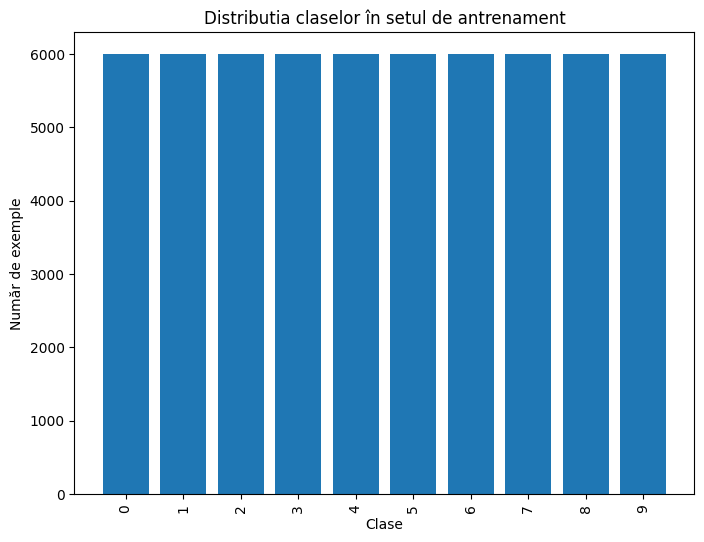

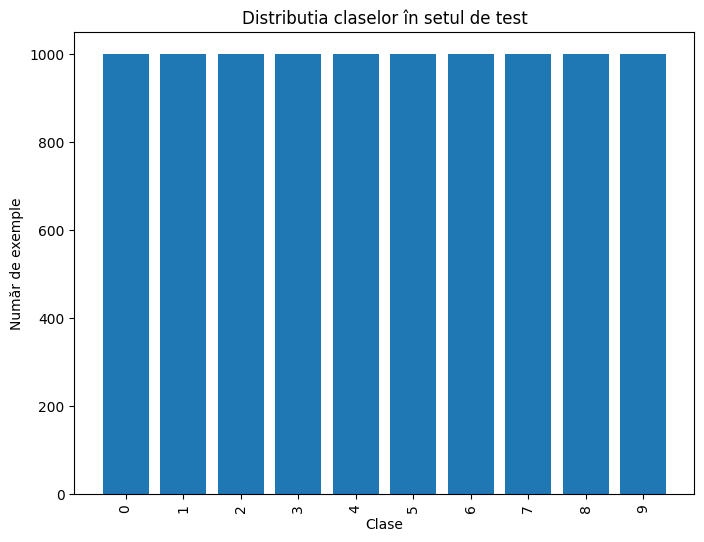

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(labels, title="Distributia claselor"):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(8, 6))
    plt.bar(unique, counts, tick_label=unique)
    plt.xlabel('Clase')
    plt.ylabel('Număr de exemple')
    plt.title(title)
    plt.xticks(rotation=90)  
    plt.show()


plot_class_distribution(train_labels, title="Distributia claselor în setul de antrenament")


plot_class_distribution(test_labels, title="Distributia claselor în setul de test")


### Cantitatea de variabilitate explicata de PCA

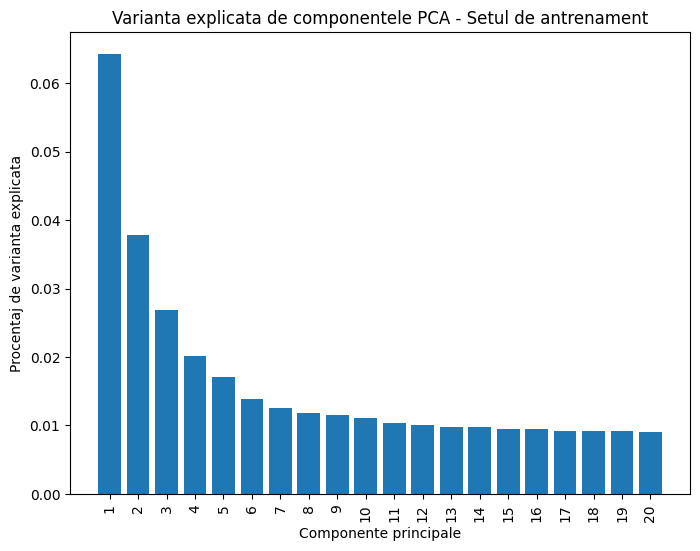

In [28]:
import matplotlib.pyplot as plt


def plot_pca_variance_explained(pca, title="Varianta explicata de componentele PCA"):
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, tick_label=range(1, len(explained_variance) + 1))
    plt.xlabel('Componente principale')
    plt.ylabel('Procentaj de varianta explicata')
    plt.title(title)
    plt.xticks(rotation=90)  
    plt.show()


plot_pca_variance_explained(pca, title="Varianta explicata de componentele PCA - Setul de antrenament")


###  Varianta cumulativa explicata de componentele principale (PCA).

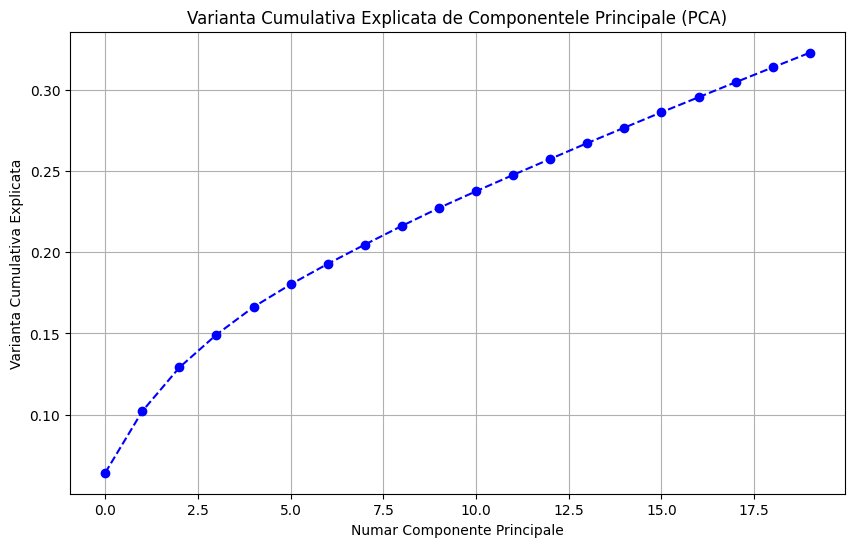

In [30]:
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Varianta Cumulativa Explicata de Componentele Principale (PCA)')
plt.xlabel('Numar Componente Principale')
plt.ylabel('Varianta Cumulativa Explicata')
plt.grid(True)
plt.show() 

### Vizualizarea punctelor cheie identificate în imagini prin suprapunerea lor peste imaginea originală

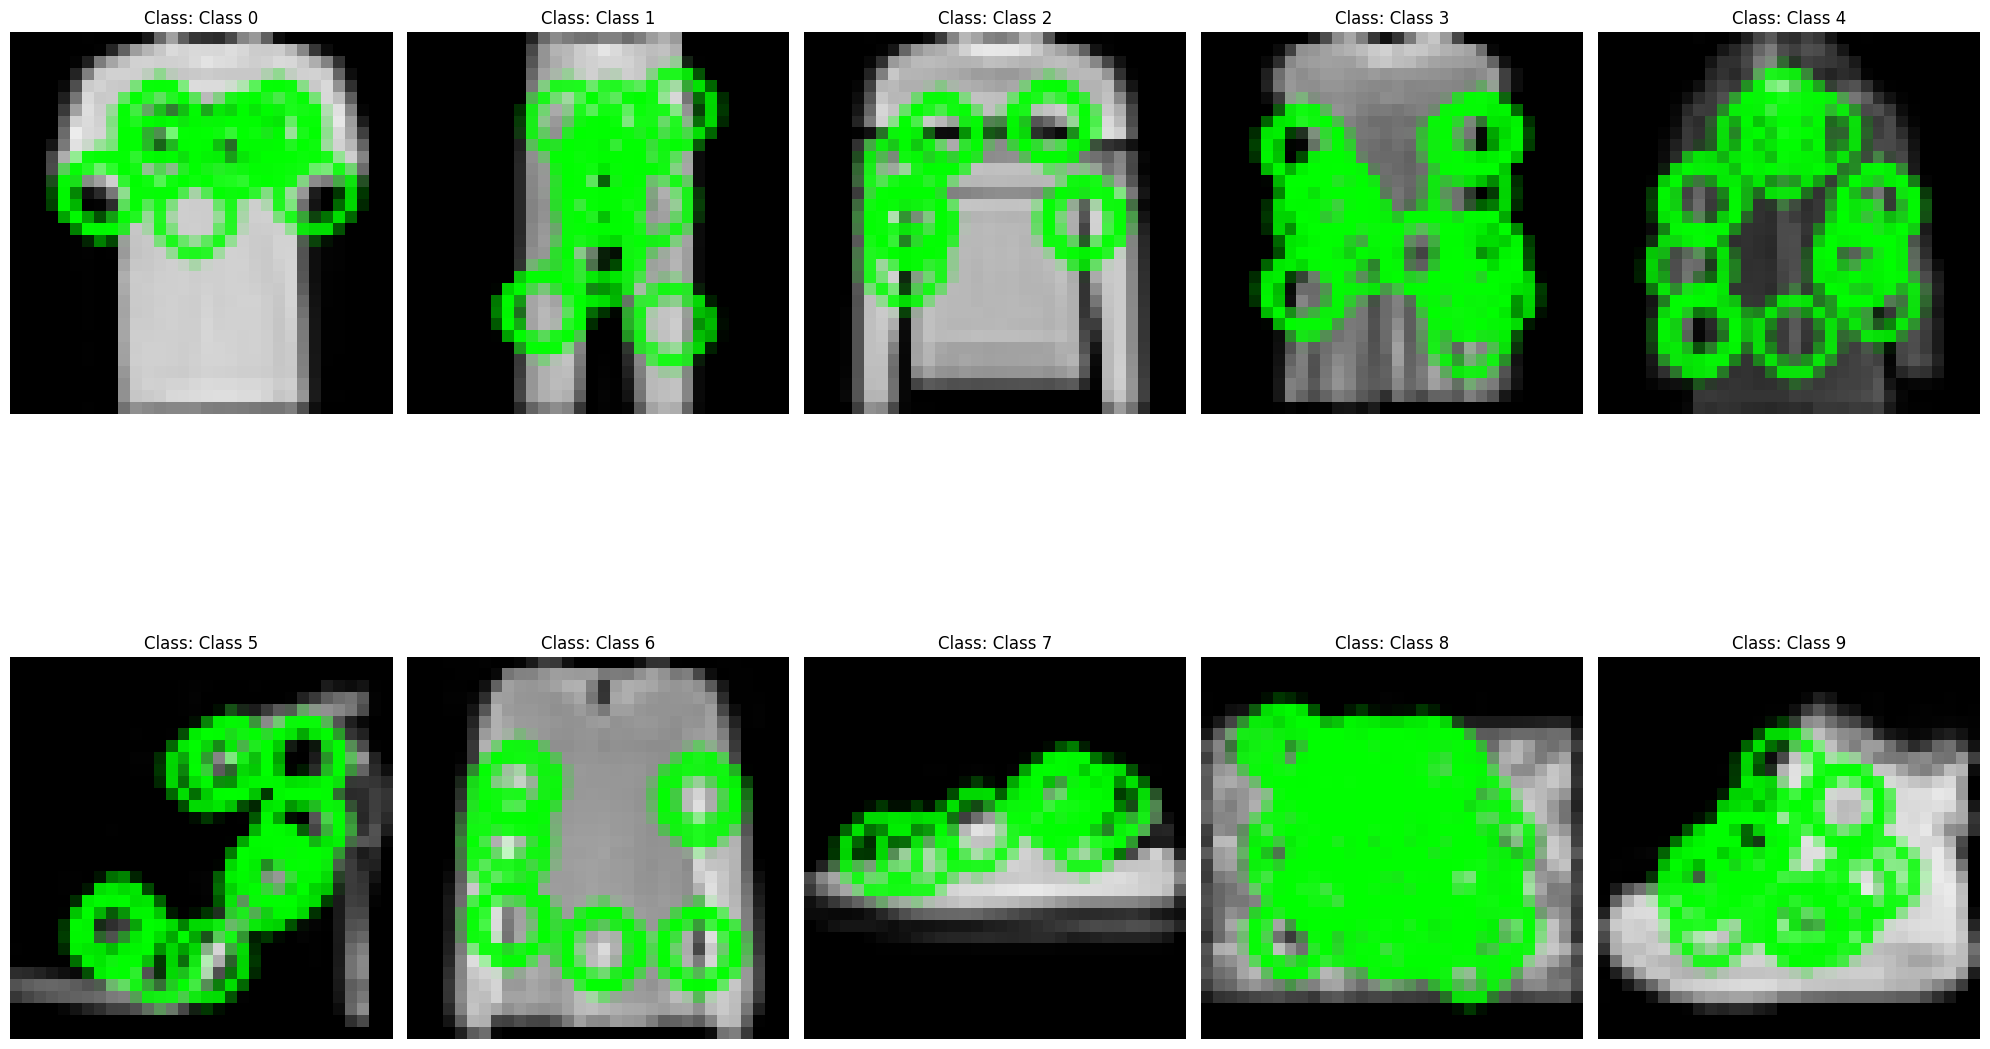

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_orb_keypoints(images, labels, class_names, n=10):
    orb = cv2.ORB_create(nfeatures=300, scaleFactor=1.2, edgeThreshold=6, patchSize=4)
    
    plt.figure(figsize=(20, 15))  
    for i in range(n):
        kp, _ = orb.detectAndCompute(images[i], None)
        image_with_keypoints = cv2.drawKeypoints(images[i], kp, None, color=(0, 255, 0))
        
        row = i // 5  
        col = i % 5   
        
        plt.subplot(2, 5, i+1) 
        plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
        
       
        class_name = class_names[labels[i]]
        plt.title(f"Class: {class_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def select_one_image_from_each_class(train_resized, train_labels, n_classes=10):
    selected_images = []
    selected_labels = []
    
    for class_id in range(n_classes):
  
        class_indices = np.where(train_labels == class_id)[0]
        if len(class_indices) > 0:
            selected_images.append(train_resized[class_indices[0]]) 
            selected_labels.append(class_id) 
    
    return selected_images, selected_labels

class_names = [f"Class {i}" for i in range(10)]  

selected_images, selected_labels = select_one_image_from_each_class(train_resized, train_labels, n_classes=10)


display_orb_keypoints(selected_images, selected_labels, class_names, n=10)


In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile
import xgboost as xgb
from skimage.feature import hog
import matplotlib.pyplot as plt
import pandas as pd


log_reg = LogisticRegression(max_iter=5000)
log_reg_params = {'C': [0.1, 1, 10], 'multi_class': ['ovr', 'multinomial']}
log_reg_search = RandomizedSearchCV(log_reg, log_reg_params, cv=5)
log_reg_search.fit(train_selected, train_labels)




/home/regelepirat/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000),
                   param_distributions={'C': [0.1, 1, 10],
                                        'multi_class': ['ovr', 'multinomial']})

In [25]:
# # SVM
# svm = SVC()
# svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly']}
# svm_search = RandomizedSearchCV(svm, svm_params, cv=5)
# svm_search.fit(train_selected, train_labels)



In [ ]:
# # Random Forest
# rf = RandomForestClassifier()
# rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'max_features': ['sqrt', 'log2']}
# rf_search = RandomizedSearchCV(rf, rf_params, cv=5)
# rf_search.fit(train_selected, train_labels)

In [ ]:
# # XGBoost
# xgb_model = xgb.XGBClassifier()
# xgb_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'learning_rate': [0.01, 0.1]}
# xgb_search = RandomizedSearchCV(xgb_model, xgb_params, cv=5)
# xgb_search.fit(train_selected, train_labels)

In [42]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

models = [log_reg_search]
model_names = ['Logistic Regression']

results_list = []

for model_name, model in zip(model_names, models):
    y_pred = model.predict(test_images)
    
    accuracy = accuracy_score(test_labels, y_pred)  
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, y_pred, average=None)  
    
    accuracy_mean = np.mean(accuracy)
    accuracy_variance = np.var(accuracy)
    
    precision_mean = np.mean(precision)
    precision_variance = np.var(precision)
    
    recall_mean = np.mean(recall)
    recall_variance = np.var(recall)
    
    f1_mean = np.mean(f1)
    f1_variance = np.var(f1)
    
    results_list.append({
        "Model": model_name,
        "Params": model.best_params_,
        "Accuracy_Mean": f"{accuracy_mean:.3f}",
        "Precision_Mean": f"{precision_mean:.3f}",
        "Recall_Mean": f"{recall_mean:.3f}",
        "F1_Mean": f"{f1_mean:.3f}",
        "Accuracy_Variance": f"{accuracy_variance:.3f}",
        "Precision_Variance": f"{precision_variance:.3f}",
        "Recall_Variance": f"{recall_variance:.3f}",
        "F1_Variance": f"{f1_variance:.3f}"
    })
    
    cm = confusion_matrix(test_labels, y_pred)  
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

results = pd.DataFrame(results_list)
print(results)


ValueError: X has 784 features, but LogisticRegression is expecting 20 features as input.